# Final performance of XGBoost
## Code for computing the final performance of XGBoost model using test set

In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report,\
                            confusion_matrix, accuracy_score, f1_score, precision_recall_curve

In [2]:
"""Functions def"""
def read_data(raw_clinical_note):
    """Function for loading data"""
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def opening_model(path_model):
    """Function for Opening model """
    loaded_model = joblib.load(path_model)
    return loaded_model

def plot_pr_curve(test_y, model_probs):
    from sklearn.metrics import PrecisionRecallDisplay
    display = PrecisionRecallDisplay.from_predictions(test_y, model_probs, name="XGBoost")
    _ = display.ax_.set_title("Precision-Recall curve")
    plt.show()

def generating_metrics(model, x, y):
    """Function for computing metrics"""
    y_pred_proba = model.predict_proba(x)[:, 1]
    y_pred = model.predict(x)
    acc = accuracy_score(y,y_pred)
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    auc_score = auc(false_positive_rate, true_positive_rate)
    f1 = f1_score(y, y_pred)

    # Precision or positive predictive value
    ppv = tp/(tp+fp)
    # Negative predictive value
    npv = tn/(tn+fn)

    #plot_pr_curve(y, y_pred_proba)
    return auc_score, sensitivity, specificity, f1, acc, false_positive_rate, true_positive_rate, ppv,npv, y_pred_proba

def plot_roc(model,X_test, y_test,name):
    auc_test, sens_test, spec_test, f1_test, acc_test,fpr_test, tpr_test,ppv_test,npv_test, y_pred_proba = generating_metrics(model, X_test, y_test)
    
    fig = plt.figure(figsize=(10,5)) #x,y
    plt.subplots_adjust(wspace=0.4,hspace=0.6)

    #ROC curve
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.plot(fpr_test, tpr_test, label='AUC=%0.2f' % auc_test, color='darkorange')
    ax1.set_xlabel('1 - Specificity \n (False positive rate)')
    ax1.set_ylabel('Sensitivity \n (True positive rate)')
    ax1.legend(loc='best')
    ax1.set_title('ROC curve')

    #PR curve
    ax2 = plt.subplot(1, 2, 2)
    no_skill = len(y_test[y_test==1]) / len(y_test) # calculate the no skill line as the proportion of the positive class
    ax2.plot([0, 1], [no_skill, no_skill], 'k--') # plot the no skill precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba) # plot model precision-recall curve
    auc_score = auc(recall, precision)
    ax2.plot(recall, precision, marker='.', label='PR AUC=%.3f'% auc_score, color='darkorange')
    ax2.set_xlabel('Recall \n (True positive rate)')
    ax2.set_ylabel('Precision \n (Positive Predictive Value )')
    ax2.set_title('Precision-Recall curve')
    ax2.legend(loc='best')
    

    print("**** Metrics on test set ****")
    print('PR AUC: %.3f' % auc_score)
    print("AUC:", np.round(auc_test,3))
    print("Sensitivity:", np.round(sens_test,3))
    print("Specificity:", np.round(spec_test,3))
    print("F1_score:", np.round(f1_test,3))
    print("Accuracy:", np.round(acc_test,3))
    print("PPV:", np.round(ppv_test,3))
    print("NPV:", np.round(npv_test,3))


In [3]:
"""Loading test sets"""
path = "C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/BCM/"
x_test = pd.read_csv(path + "x_test.csv")
y_test = pd.read_csv(path + "y_test.csv")
print ("x_test:", x_test.shape, "y_test:",y_test.shape)

x_test: (2313, 35) y_test: (2313, 2)


In [4]:
"""Drop columns"""
x_test = x_test.drop(['Unnamed: 0'],axis=1)
y_test = y_test.drop(['Unnamed: 0'],axis=1)
print ("x_test:", x_test.shape, "y_test:",y_test.shape)

x_test: (2313, 34) y_test: (2313, 1)


In [5]:
"""Check the classes"""
print(y_test.value_counts())

lethality
0            1989
1             324
dtype: int64


In [6]:
"""Loading model"""
model = opening_model(path+"XGBoost_model_0.pkl")
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=422, rate_drop=0.3,
              reg_alpha=0.03, reg_lambda=1, scale_pos_weight=6.127118644067797,
              seed=422, subsample=0.3, tree_method='exact',
              validate_parameters=1, verbosity=None)

**** Metrics on test set ****
PR AUC: 0.503
AUC: 0.788
Sensitivity: 0.836
Specificity: 0.74
F1_score: 0.487
Accuracy: 0.754
PPV: 0.344
NPV: 0.965


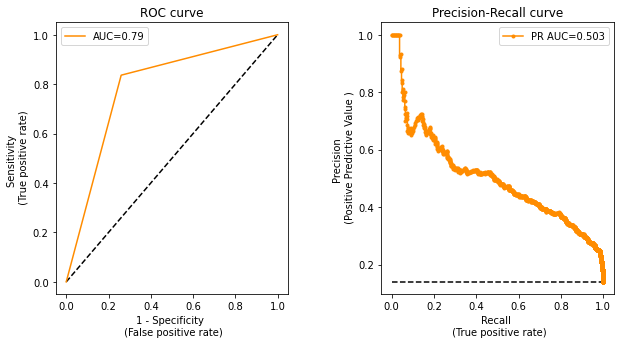

In [7]:
"""Computing metrics"""
y_test = np.array(y_test)
plot_roc(model,x_test, y_test,"XGBoost")
plt.savefig(path+'plot_roc_XBG_0.pdf')